In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.use("TkCairo")

In [2]:
    
## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
# k = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as integ

import scipy.io as sio

import scipy.optimize as opt

import scipy.special as spl

In [3]:
misloc_pack_path = os.path.join(
    os.path.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'Mispolarization',
    'python',
#     'gitted',
    )

sys.path.append(misloc_pack_path)

import misloc_mispol_package as mmp
import misloc_mispol_package.calc.coupled_dipoles as cp
import misloc_mispol_package.optics.anal_foc_diff_fields as aff

In [4]:
sys.path.append('..')
import twosphere_temperature as tst
import pti_model as pti

In [5]:
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 150,  # to adjust notebook inline plot size
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100,
    'axes.formatter.limits' : [-3, 3]
}
mpl.rcParams.update(params)

## Build a thing to move axis multiplier to label
## https://stackoverflow.com/questions/45760763/how-to-move-the-y-axis-scale-factor-to-the-position-next-to-the-y-axis-label
## -----

# import numpy as np
# import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

class Labeloffset():
    def __init__(self,  ax, label="", axis="y"):
        self.axis = {"y":ax.yaxis, "x":ax.xaxis}[axis]
        self.label=label
        ax.callbacks.connect(axis+'lim_changed', self.update)
        ax.figure.canvas.draw()
        self.update(None)

    def update(self, lim):
        fmt = self.axis.get_major_formatter()
        self.axis.offsetText.set_visible(False)
        self.axis.set_label_text(self.label + " (" + fmt.get_offset() + ")" )

    

Path to temperature dependent dielectric data

In [6]:
path_to_diel_data = os.path.join(
    os.path.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'DMREF',
    'dielectrics'
    )

In [7]:
os.path.exists(path_to_diel_data)

True

#### System parameters

In [8]:
a1 = 10
# eps_back = 1.473**2
eps_back = 1.473**2

plot_hws = np.linspace(1.8, 2.6, 300)

sensorsize_nm = 1000
ergpers_per_watt = 1e7
cm_per_nm = 1e-7

# pump_intensity = pump_power_watts*ergpers_per_watt/(300*cm_per_nm)**2.
## Define field magnitude from intensity in ergs/(cm^2*s)
# E_pump_mag = ((8*np.pi/c)*pump_intensity)**0.5 
# E_pump_mag = (pump_power_watts*ergpers_per_watt)**0.5
## Try Baffou intensity from APL 2009, DOI: 10.1063/1.3116645
pump_intensity_watts_per_cm2 = 1e5/2
pump_power_watts = (
    pump_intensity_watts_per_cm2 * np.pi*(150*cm_per_nm)**2
    )
E_pump_mag = (pump_power_watts*ergpers_per_watt)**0.5

## Define probe intensity
probe_power_watts = 1.1*1e-3 
probe_intensity = (
    probe_power_watts*ergpers_per_watt
    /(300*cm_per_nm)**2.
    )
E_probe_mag = ((8*np.pi/c)*probe_intensity)**0.5

probe_enei = 2.5
# probe_enei = anti_enei
b1 = a1 

## Assign material porperties of gold
# au_eps_inf=9.82335326  # eps_inf
# au_w_p=9.06705560/hbar  # w_p
# au_gamma=0.0334860149/hbar  # gamma
## BEM Drude parameters
au_eps_inf=10  # eps_inf
au_w_p=9.0705/hbar  # w_p
au_gamma=0.0660/hbar  # gamma

kappa_glycerol = 0.292 

m_per_cm = 1e-2
pump_intensity_watts_per_cm2/(m_per_cm)**2

## polarizability I have been using based on some Drude parameters ([probably from BEM])
def alpha_1_of_hw(hw):
    return cp.sparse_Mie_sphere_polarizability_Drude(
        w=hw/hbar, 
        a=a1*1e-7, 
        eps_inf=au_eps_inf,  # eps_inf
        w_p=au_w_p,  # w_p
        gamma=au_gamma,  # gamma
        eps_b=eps_back,  # eps_b
#         a=41*1e-7
        )


Load n and k data and convert to epsilon

In [9]:
## Initialize dictionaries to hold the datas
hw_n_T_dict = {}
hw_eps_T_dict = {}

## loop through temperatures to store n&k and calculate epsilon
for i in range(0, 100):
    lambda_n_and_k = np.loadtxt(
        os.path.join(path_to_diel_data, f'au_Conor_{i:d}K.txt'),
        skiprows=3
        )
    ## Data is in DDA format, meaning 
    ## wavelengths in micron, n, k
    lambda_n_and_k[:, 0] *= 1e3 ## nm per micron
    
    n_compl = lambda_n_and_k[:, 1] + 1j*lambda_n_and_k[:, 2]

    ## Assuming epsilon = (n + ik)^2
    hbarw_diel, eps_0K = (
        1240/lambda_n_and_k[:, 0],
        (n_compl)**2.
        )
    
    ## Store data in dictionaries
    hw_eps_T_dict[f'hw_eps_{i:d}K'] = np.vstack((hbarw_diel, eps_0K))
    hw_n_T_dict[f'hw_n_{i:d}K'] = np.vstack((hbarw_diel, n_compl))

## Plot n as a function of T, is it linear as we assumed?

In [10]:
## Get all n data into array to calculate finite difference derivitive

## Real part first
## ---------------
## Initialize array: rows correspond to wavelengths, columns to temperatures
nr_array = np.zeros((
    len(hw_n_T_dict[f'hw_n_0K'][0])+1, 101
    )) 

## use first column and row for labels
nr_array[1:, 0] = hw_n_T_dict[f'hw_n_0K'][0].real
nr_array[0, 1:] = np.linspace(0, 99, 100)

## Populate array with n values from dictionary
for i in range(100):
    nr_array[1:, i+1] = hw_n_T_dict[f'hw_n_{i:d}K'][1].real

## Then Imaginary part
## -------------------
ni_array = np.zeros((
    len(hw_n_T_dict[f'hw_n_0K'][0])+1, 101
    )) 

## use first column and row for labels
ni_array[1:, 0] = hw_n_T_dict[f'hw_n_0K'][0].real
ni_array[0, 1:] = np.linspace(0, 99, 100)

## Populate array with n values from dictionary    
for i in range(100):
    ni_array[1:, i+1] = hw_n_T_dict[f'hw_n_{i:d}K'][1].imag


## Try plotting dn/dt

In [11]:

## Calculate finite difference
dnr_dt_array = np.diff(nr_array[:, 1:], axis=1)
## -------------------


## Calculate finite difference
dni_dt_array = np.diff(ni_array[:, 1:], axis=1)
## -------------------

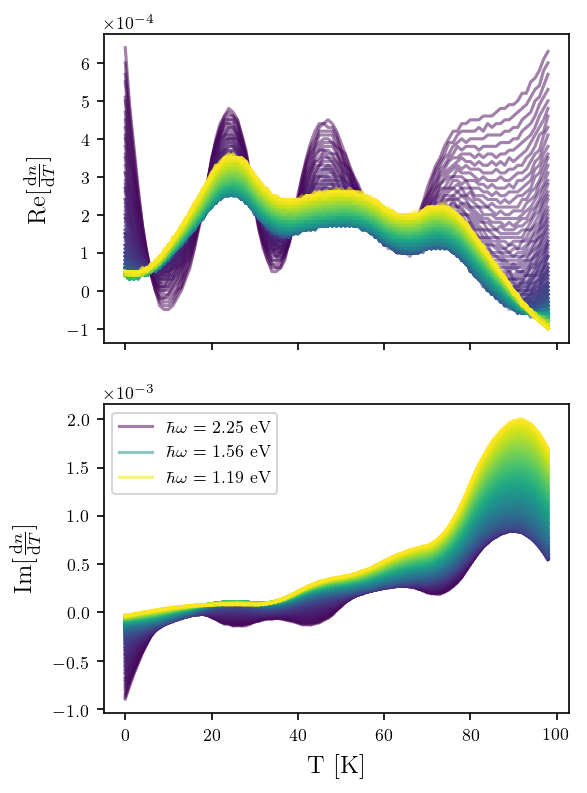

In [12]:
## Build figure
## ------------
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,6))

## Loop through tempertures of Re[n]
for i, n_of_T_at_a_freq in enumerate(dnr_dt_array):
    if i is 0:
        continue
    ## Grab a few frequeny labels for legend
    if ((i == 1) or (i == 145) or (i == 290)):
        label = r'$\hbar\omega = $'+f' {nr_array[i, 0]:.2f} eV'
    else: label=None
    
    axs[0].plot(
        nr_array[0, 1:-1], 
        n_of_T_at_a_freq, 
        label=label,
        c=mpl.cm.viridis(i/296), 
        alpha=.5)

## Loop through tempertures of Im[n]
for i, n_of_T_at_a_freq in enumerate(dni_dt_array):
    if i is 0:
        continue
    ## Grab a few frequeny labels for legend
    if ((i == 1) or (i == 145) or (i == 290)):
        label = r'$\hbar\omega = $'+f' {ni_array[i, 0]:.2f} eV'
    else: label=None
        
    axs[1].plot(
        ni_array[0, 1:-1], 
        n_of_T_at_a_freq, 
        c=mpl.cm.viridis(i/296), 
        label=label,
        alpha=.5)


axs[0].set_ylabel(r'$\mathrm{Re}[\frac{\mathrm{d}n}{\mathrm{d}T}]$')
axs[1].set_ylabel(r'$\mathrm{Im}[\frac{\mathrm{d}n}{\mathrm{d}T}]$')
axs[1].set_xlabel('T [K]')
axs[1].legend()

#### plot dn_dt / n to compare to what I was doing before

## dielectric function 

/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


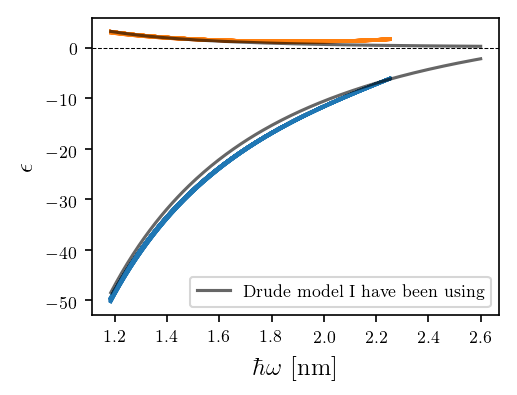

In [13]:
for i in range(100):
    plt.plot(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][0], 
        np.real(hw_eps_T_dict[f'hw_eps_{i:d}K'][1]), 
        c='C0',  
        alpha=i/100,
        )
    plt.plot(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][0], 
        np.imag(hw_eps_T_dict[f'hw_eps_{i:d}K'][1]), 
        c='C1',  
        alpha=i/100
        )
    
plt.ylabel(r'$\epsilon$')
plt.xlabel(r'$\hbar\omega$ [nm]')

hw_h = np.linspace(hw_eps_T_dict[f'hw_eps_{i:d}K'][0].min(), 2.6, 200)

drude_model = cp.drude_model(hw_h/hbar, eps_inf=au_eps_inf, w_p=au_w_p, gamma=au_gamma)

plt.plot(
    hw_h,
    np.real(drude_model),
    c = 'k',
    label='Drude model I have been using',
    alpha=.6
    )
plt.plot(
    hw_h,
    np.imag(drude_model),
    c = 'k',
    alpha=.6
    )

plt.axhline(0, lw=.5, ls='--', c='k')
plt.legend()

/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, '$\\hbar\\omega$ [nm]')

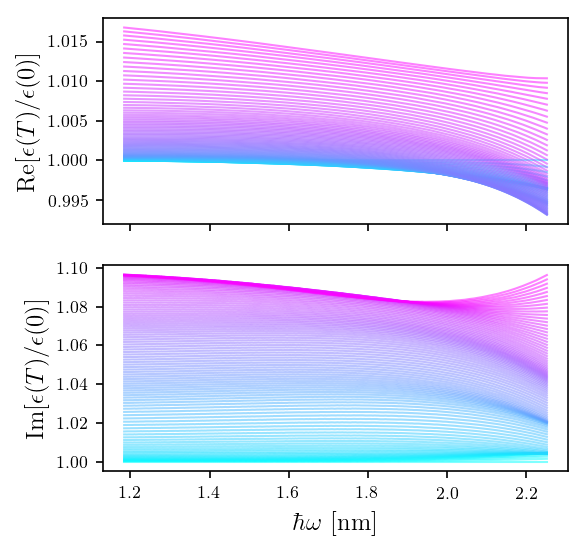

In [14]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,4))
for i in range(100):
    axs[0].plot(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][0], 
        np.real(hw_eps_T_dict[f'hw_eps_{i:d}K'][1])/np.real(hw_eps_T_dict[f'hw_eps_0K'][1]), 
        lw=1,
        c=plt.cm.cool(i/100),  alpha=.5)
    axs[1].plot(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][0], 
        np.imag(hw_eps_T_dict[f'hw_eps_{i:d}K'][1])/np.imag(hw_eps_T_dict[f'hw_eps_0K'][1]), 
        lw=1,
        c=plt.cm.cool(i/100),  alpha=.5)
    
# axs[0].plot(
#     hw_eps_T_dict[f'hw_eps_{i:d}K'][0], 
#     np.real(drude_model)/np.real(hw_eps_T_dict[f'hw_eps_0K'][1]),
#     c = 'k',
#     alpha=.6
#     )
# axs[1].plot(
#     hw_eps_T_dict[f'hw_eps_{i:d}K'][0], 
#     np.imag(drude_model)/np.imag(hw_eps_T_dict[f'hw_eps_0K'][1]),
#     c = 'k',
#     alpha=.6
#     )
    
axs[0].set_ylabel(r'Re[$\epsilon(T)/\epsilon(0)$]')
axs[1].set_ylabel(r'Im[$\epsilon(T)/\epsilon(0)$]')
axs[1].set_xlabel(r'$\hbar\omega$ [nm]')

Then I'd like to compare the polarizability at different temperatures, or even spectra

Text(0.5, 0, '$\\hbar\\omega$ [nm]')

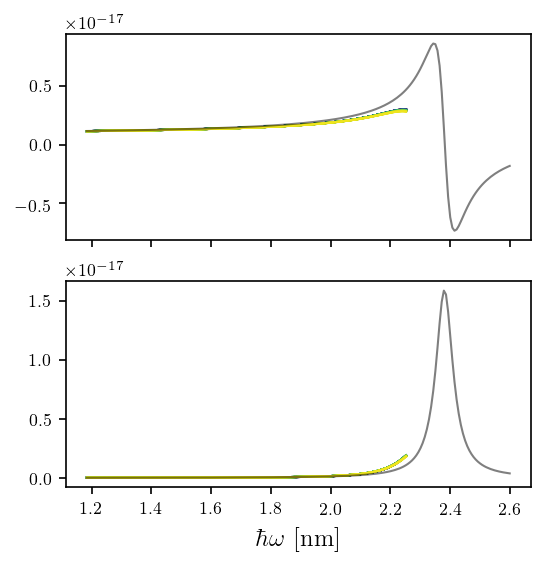

In [15]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,4))

for i in range(100):
    
    hw = hw_eps_T_dict[f'hw_eps_{i:d}K'][0]
    
    alpha_ofT = cp.sparse_sphere_polarizability_Mie(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][1],
        eps_b=eps_back,
        a=a1*1e-7,
        w=hw,
        )[:, 0,0]
    
    axs[0].plot(
        hw, 
        np.real(alpha_ofT), 
        lw=1,
        c=plt.cm.viridis(i/100),  alpha=.5)
    axs[1].plot(
        hw, 
        np.imag(alpha_ofT), 
        lw=1,
        c=plt.cm.viridis(i/100),  alpha=.5)

alpha_Drude = alpha_1_of_hw(hw_h)[:, 0,0]

axs[0].plot(
    hw_h, 
    np.real(alpha_Drude), 
    lw=1,
    c='k',  alpha=.5)
axs[1].plot(
    hw_h, 
    np.imag(alpha_Drude), 
    lw=1,
    c='k',  alpha=.5)

  
# axs[0].set_ylabel(r'Re[$\alpha(T)/\alpha(0)$]')
# axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
axs[1].set_xlabel(r'$\hbar\omega$ [nm]')



Text(0.5, 0, '$\\hbar\\omega$ [nm]')

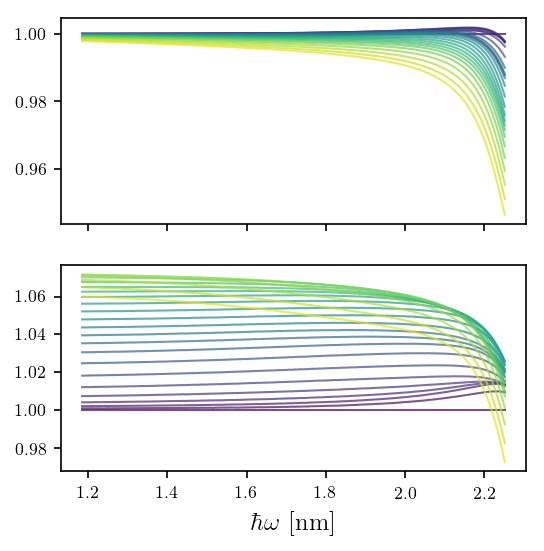

In [16]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,4))

alpha_of0K = cp.sparse_sphere_polarizability_Mie(
    hw_eps_T_dict[f'hw_eps_0K'][1],
    eps_b=eps_back,
    a=a1*1e-7,
    w=hw_eps_T_dict[f'hw_eps_0K'][0],
    )[:, 0,0]
    
for i in range(100):

    if i % 4 is not 0:
        continue
    
    hw = hw_eps_T_dict[f'hw_eps_{i:d}K'][0]
    
    alpha_ofT = cp.sparse_sphere_polarizability_Mie(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][1],
        eps_b=eps_back,
        a=a1*1e-7,
        w=hw,
        )[:, 0,0]

    
    axs[0].plot(
        hw, 
        np.real(alpha_ofT)/np.real(alpha_of0K), 
        lw=1,
        c=plt.cm.viridis(i/100),  
        alpha=.7,
        )
    axs[1].plot(
        hw, 
        np.imag(alpha_ofT)/np.imag(alpha_of0K), 
        lw=1,
        c=plt.cm.viridis(i/100),  
        alpha=.7,
        )

# alpha_Drude = alpha_1_of_hw(hw)[:, 0,0]

# axs[0].plot(
#     hw, 
#     np.real(alpha_Drude), 
#     lw=1,
#     c='k',  alpha=.5)
# axs[1].plot(
#     hw, 
#     np.imag(alpha_Drude), 
#     lw=1,
#     c='k',  alpha=.5)

  
# axs[0].set_ylabel(r'Re[$\alpha(T)/\alpha(0)$]')
# axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
axs[1].set_xlabel(r'$\hbar\omega$ [nm]')




Try fitting a drude model to the 0K data

In [17]:
fit_cutoff = 2.22

def drude_cost(param, *args):

    eps_inf, w_p, gamma = param
    
    hw, data = args
    
    model = cp.drude_model(hw/hbar, eps_inf=eps_inf, w_p=w_p, gamma=gamma)

    res = (model - data)*(hw>fit_cutoff)
    
    return np.array([res.real, res.imag]).ravel()
    

In [18]:
ini_params = [au_eps_inf, au_w_p, au_gamma]

drude_fit_0K = opt.least_squares(
    drude_cost,
    ini_params,
    args=(hw_eps_T_dict[f'hw_eps_0K'][0], hw_eps_T_dict[f'hw_eps_0K'][1]),
    x_scale=[1e2, 1e16, 1e14]
    )

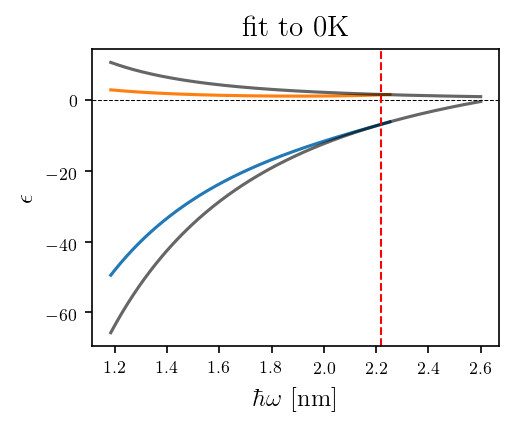

In [19]:

# for i in range(100):
#     plt.plot(hw_eps_T_dict[f'hw_eps_{i:d}K'][0], np.real(hw_eps_T_dict[f'hw_eps_{i:d}K'][1]), c='C0',  alpha=i/100)
#     plt.plot(hw_eps_T_dict[f'hw_eps_{i:d}K'][0], np.imag(hw_eps_T_dict[f'hw_eps_{i:d}K'][1]), c='C1',  alpha=i/100)
# for i in range(100):
plt.plot(hw_eps_T_dict[f'hw_eps_0K'][0], np.real(hw_eps_T_dict[f'hw_eps_0K'][1]), c='C0',  alpha=i/100)
plt.plot(hw_eps_T_dict[f'hw_eps_0K'][0], np.imag(hw_eps_T_dict[f'hw_eps_0K'][1]), c='C1',  alpha=i/100)
    
plt.ylabel(r'$\epsilon$')
plt.xlabel(r'$\hbar\omega$ [nm]')


hw_h = np.linspace(hw_eps_T_dict[f'hw_eps_{i:d}K'][0].min(), 2.6, 200)
fit_drude =  cp.drude_model(hw_h/hbar, *drude_fit_0K['x'])
plt.plot(
    hw_h,
    np.real(fit_drude),
    c = 'k',
    alpha=.6
    )
plt.plot(
    hw_h,
    np.imag(fit_drude),
    c = 'k',
    alpha=.6
    )

plt.axhline(0, lw=.5, ls='--', c='k')

plt.title('fit to 0K')
plt.axvline(fit_cutoff, c='red', lw=1, ls='--')

Text(0.5, 0, '$\\hbar\\omega$ [nm]')

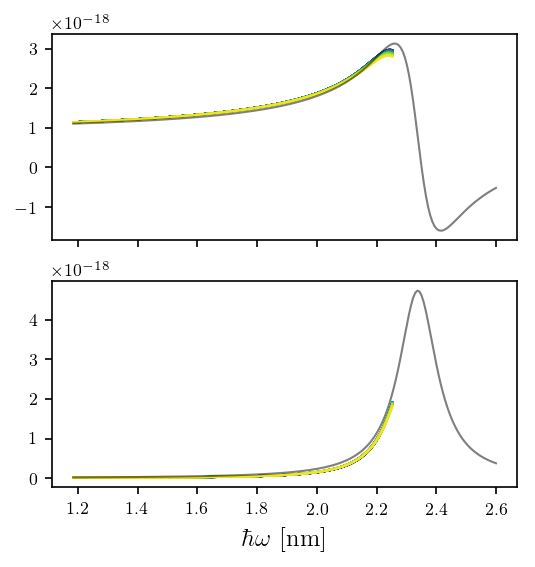

In [20]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,4))

for i in range(100):
    
    hw = hw_eps_T_dict[f'hw_eps_{i:d}K'][0]
    
    alpha_ofT = cp.sparse_sphere_polarizability_Mie(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][1],
        eps_b=eps_back,
        a=a1*1e-7,
        w=hw,
        )[:, 0,0]
    
    axs[0].plot(
        hw, 
        np.real(alpha_ofT), 
        lw=1,
        c=plt.cm.viridis(i/100),  alpha=.5)
    axs[1].plot(
        hw, 
        np.imag(alpha_ofT), 
        lw=1,
        c=plt.cm.viridis(i/100),  alpha=.5)

def alpha_fitDrude_of_hw(hw):
    return cp.sparse_Mie_sphere_polarizability_Drude(
        w=hw/hbar, 
        a=a1*1e-7, 
        eps_inf=drude_fit_0K['x'][0],  # eps_inf
        w_p=drude_fit_0K['x'][1],  # w_p
        gamma=drude_fit_0K['x'][2],  # gamma
        eps_b=eps_back,  # eps_b
#         a=41*1e-7
        )
alpha_Drude = alpha_fitDrude_of_hw(hw_h)[:, 0,0]

axs[0].plot(
    hw_h, 
    np.real(alpha_Drude), 
    lw=1,
    c='k',  alpha=.5)
axs[1].plot(
    hw_h, 
    np.imag(alpha_Drude), 
    lw=1,
    c='k',  alpha=.5)

  
# axs[0].set_ylabel(r'Re[$\alpha(T)/\alpha(0)$]')
# axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
axs[1].set_xlabel(r'$\hbar\omega$ [nm]')



# Compare data to linear taylor expansion I have been using for PTImages

In [21]:
## Get 0K polarizability from linear model (CM)
heated_particle = pti.single_particle_image(
    hw_h, 
    eps_inf=drude_fit_0K['x'][0],  # eps_inf
    w_p=drude_fit_0K['x'][1],  # w_p
    gamma=drude_fit_0K['x'][2],  # gamma
    E_probe=E_probe_mag,
    eps0=eps_back)

linear_alpha_at0K = heated_particle.alpha_of_T(0, b1*1e-7, a1*1e-7)

## Build Mie polarizability with Drude model
alpha_Drude = alpha_fitDrude_of_hw(hw_h)[:, 0,0]

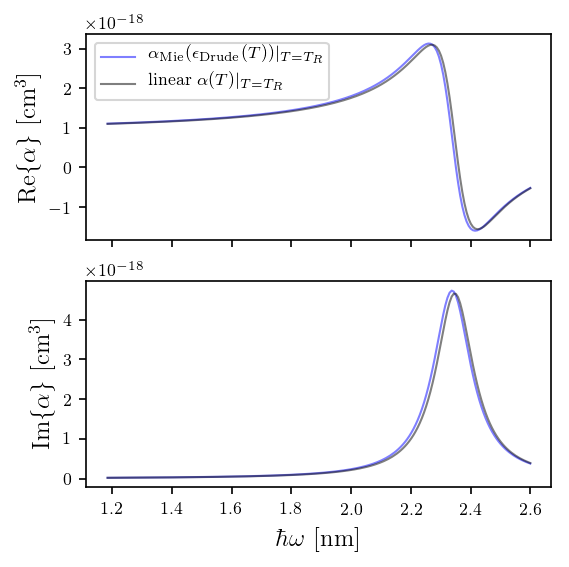

In [22]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,4))


axs[0].plot(
    hw_h, 
    np.real(alpha_Drude), 
    label=r'$\alpha_\mathrm{Mie}(\epsilon_\mathrm{Drude}(T))|_{T=T_R}$',
    lw=1,
    c='blue',  alpha=.5)
axs[1].plot(
    hw_h, 
    np.imag(alpha_Drude), 
    lw=1,
    c='blue',  alpha=.5)

axs[0].plot(
    hw_h, 
    np.real(linear_alpha_at0K),
    label=r'linear $\alpha(T)|_{T=T_R}$',
    lw=1,
    c='k',  alpha=.5)
axs[1].plot(
    hw_h, 
    np.imag(linear_alpha_at0K),
    lw=1,
    c='k',  alpha=.5)

  
# axs[0].set_ylabel(r'Re[$\alpha(T)/\alpha(0)$]')
# axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
axs[1].set_xlabel(r'$\hbar\omega$ [nm]')
axs[0].set_ylabel(r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$')
axs[1].set_ylabel(r'$\mathrm{Im}\{\alpha\}$ $[\mathrm{cm}^3]$')

axs[0].legend()



This looks a lot better then I expected. 

In [23]:
drude_fit_0K['x']

array([1.70602660e+01, 1.65035553e+16, 2.32857278e+14])

In [24]:
heated_particle = pti.single_particle_image(
    hw_h, 
    eps_inf=drude_fit_0K['x'][0],  # eps_inf
    w_p=drude_fit_0K['x'][1],  # w_p
    gamma=drude_fit_0K['x'][2],  # gamma
    E_probe=E_probe_mag,
    eps0=eps_back)

linear_alpha_at0K = heated_particle.alpha_of_T(0, b1*1e-7, a1*1e-7)

## Build Mie polarizability from data


In [25]:
## Build polarizability from 0K data
alpha_mie_epsdata = cp.sparse_sphere_polarizability_Mie(
        hw_eps_T_dict[f'hw_eps_0K'][1],
        eps_b=eps_back,
        a=a1*1e-7,
        w=hw_eps_T_dict[f'hw_eps_0K'][0]/hbar,
        )[:, 0,0]

/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


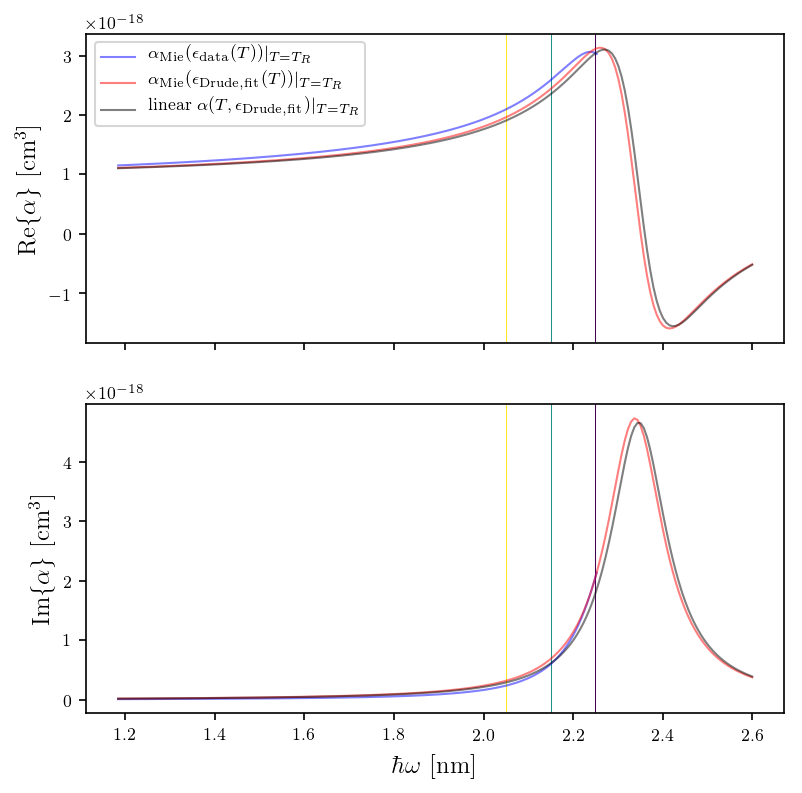

In [26]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,6))

axs[0].plot(
    hw_eps_T_dict[f'hw_eps_0K'][0], 
    np.real(alpha_mie_epsdata), 
    label=r'$\alpha_\mathrm{Mie}(\epsilon_\mathrm{data}(T))|_{T=T_R}$',
    lw=1,
    c='blue',  alpha=.5)
axs[1].plot(
    hw_eps_T_dict[f'hw_eps_0K'][0], 
    np.imag(alpha_mie_epsdata), 
    lw=1,
    c='blue',  alpha=.5)

axs[0].plot(
    hw_h, 
    np.real(alpha_Drude), 
    label=r'$\alpha_\mathrm{Mie}(\epsilon_\mathrm{Drude, fit}(T))|_{T=T_R}$',
    lw=1,
    c='red',  alpha=.5)
axs[1].plot(
    hw_h, 
    np.imag(alpha_Drude), 
    lw=1,
    c='red',  alpha=.5)

axs[0].plot(
    hw_h, 
    np.real(linear_alpha_at0K),
    label=r'linear $\alpha(T, \epsilon_\mathrm{Drude, fit})|_{T=T_R}$',
    lw=1,
    c='k',  alpha=.5)
axs[1].plot(
    hw_h, 
    np.imag(linear_alpha_at0K),
    lw=1,
    c='k',  alpha=.5)

  
# axs[0].set_ylabel(r'Re[$\alpha(T)/\alpha(0)$]')
# axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
axs[1].set_xlabel(r'$\hbar\omega$ [nm]')
axs[0].set_ylabel(r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$')
axs[1].set_ylabel(r'$\mathrm{Im}\{\alpha\}$ $[\mathrm{cm}^3]$')

axs[0].legend()

axs[0].axvline(2.25, lw=.5, zorder=0, c=mpl.cm.viridis(0))
axs[1].axvline(2.25, lw=.5, zorder=0, c=mpl.cm.viridis(0))

axs[0].axvline(2.15, lw=.5, zorder=0, c=mpl.cm.viridis(.5))
axs[1].axvline(2.15, lw=.5, zorder=0, c=mpl.cm.viridis(.5))

axs[0].axvline(2.05, lw=.5, zorder=0, c=mpl.cm.viridis(2/2))
axs[1].axvline(2.05, lw=.5, zorder=0, c=mpl.cm.viridis(2/2))




### Try different temperatures


Real $\alpha$ looks nice and linear, but I have the wrong sign.
Could fit a parabola to Im[$\alpha$], but is that worth it?

## Compare different frequencies

In [27]:
def idx_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

## Can I use a frequency dependent dndt?

In [28]:
def dndt_at_hw(hw, T):
    hw_idx = np.argmin(np.abs(hw_eps_T_dict[f'hw_eps_0K'][0] - hw))
    T_idx = T
    return dnr_dt_array[hw_idx+1, T_idx] + 1j*dni_dt_array[hw_idx+1, T_idx]

 For hw = 2.25,
dnr_dt=0.0006400000000000294,
dni_dt=-0.0009000000000001229,
 For hw = 2.15,
dnr_dt=0.0003100000000000047,
dni_dt=-0.0005999999999999339,
 For hw = 2.05,
dnr_dt=0.00017000000000000348,
dni_dt=-0.0004300000000001525,


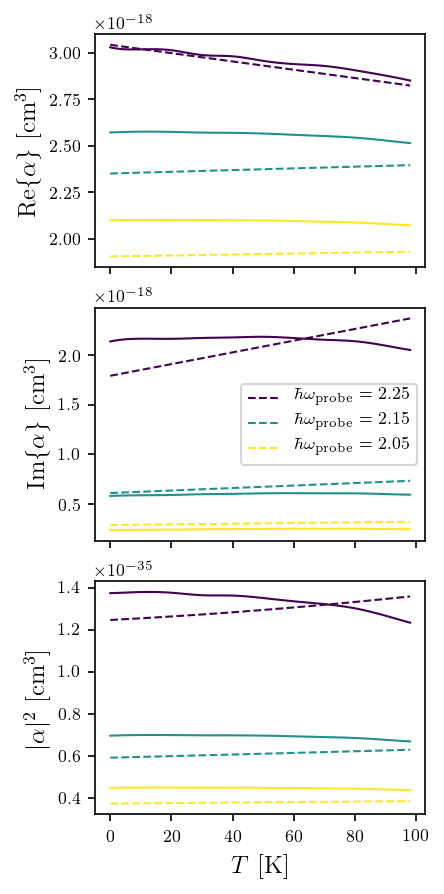

In [29]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(3,6))


def plot_data_vs_model_at(hw, color_idx, axs):
    
    alpha_mie_epsdata = np.zeros(99, dtype='complex' )
    alpha_drude = np.zeros_like(alpha_mie_epsdata)
    Ts = np.linspace(0, 98, 99)

    for i in range(99):

        eps_data = hw_eps_T_dict[f'hw_eps_{i:d}K'][1]
        hws_for_eps_data = hw_eps_T_dict[f'hw_eps_{i:d}K'][0]

        ## Get alpha at highest energy
        alpha_mie_epsdata[i] = cp.sparse_sphere_polarizability_Mie(
            eps_data[idx_nearest(hws_for_eps_data, hw)],
            eps_b=eps_back,
            a=a1*1e-7,
            w=hw/hbar,
            )[ 0,0]

        
        heated_particle = pti.single_particle_image(
            hw, 
            eps_inf=drude_fit_0K['x'][0],  # eps_inf
            w_p=drude_fit_0K['x'][1],  # w_p
            gamma=drude_fit_0K['x'][2],  # gamma
            E_probe=E_probe_mag,
            eps0=eps_back)
        alpha_drude[i] = heated_particle.alpha_of_T(
            i, 
            b1*1e-7, 
            a1*1e-7,
            dnr_dt=dndt_at_hw(hw, 0).real,
            dni_dt=dndt_at_hw(hw, 0).imag)

    print(f" For hw = {hw},")
    print(f"dnr_dt={dndt_at_hw(hw, 0).real},")
    print(f"dni_dt={dndt_at_hw(hw, 0).imag},")
    axs[0].plot(
        Ts, 
        np.real(alpha_mie_epsdata), 
        lw=1,    
    #     label=r'$\alpha_\mathrm{Mie}(\epsilon_\mathrm{Drude}(T))|_{T=T_R}$',
        c=mpl.cm.viridis(color_idx),  
        )
    axs[1].plot(
        Ts, 
        np.imag(alpha_mie_epsdata), 
        lw=1,
        c=mpl.cm.viridis(color_idx),
        )
    axs[2].plot(
        Ts, 
        np.abs(alpha_mie_epsdata)**2, 
        lw=1,
        c=mpl.cm.viridis(color_idx),
        )

    axs[0].plot(
        Ts, 
        np.real(alpha_drude), 
        label=r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}',
        lw=1,
        ls='--',
    #     label=r'linear $\alpha(T)|_{T=T_R}$',
        c=mpl.cm.viridis(color_idx),  
        )
    axs[1].plot(
        Ts, 
        np.imag(alpha_drude), 
        label=r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}',
        lw=1,
        c=mpl.cm.viridis(color_idx),  
        ls='--',
        )
    axs[2].plot(
        Ts, 
        np.abs(alpha_drude)**2, 
        label=r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}',
        lw=1,
        c=mpl.cm.viridis(color_idx),  
        ls='--',
        )

plot_data_vs_model_at(hw=2.25, color_idx=0/2, axs=axs)
plot_data_vs_model_at(hw=2.15, color_idx=1/2, axs=axs)
plot_data_vs_model_at(hw=2.05, color_idx=2/2, axs=axs)

  
axs[0].set_ylabel(r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$')
# # axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
# lo = Labeloffset(axs[0], label=r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$', axis="y")
# axs[0].yaxis.offsetText.set_visible(False)
axs[1].set_ylabel(r'$\mathrm{Im}\{\alpha\}$ $[\mathrm{cm}^3]$')
axs[2].set_ylabel(r'$|\alpha|^2$ $[\mathrm{cm}^3]$')

# axs[2, 1].set_xlabel(r'$T$ [K]')
axs[2].set_xlabel(r'$T$ [K]')

axs[1].legend()
# fig.suptitle(r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}, or {1240/hw.real:.0f} [nm]')

plt.tight_layout()

 For hw = 2.25,
dnr_dt=0.0006400000000000294,
dni_dt=-0.0009000000000001229,
 For hw = 2.15,
dnr_dt=0.0003100000000000047,
dni_dt=-0.0005999999999999339,
 For hw = 2.05,
dnr_dt=0.00017000000000000348,
dni_dt=-0.0004300000000001525,


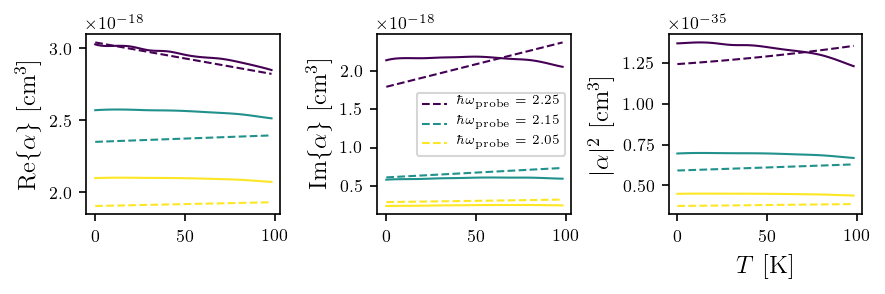

In [30]:
fig, axs = plt.subplots(1, 3, sharex=True, figsize=(6,2))


def plot_data_vs_model_at(hw, color_idx, axs):
    
    alpha_mie_epsdata = np.zeros(99, dtype='complex' )
    alpha_drude = np.zeros_like(alpha_mie_epsdata)
    Ts = np.linspace(0, 98, 99)

    for i in range(99):

        eps_data = hw_eps_T_dict[f'hw_eps_{i:d}K'][1]
        hws_for_eps_data = hw_eps_T_dict[f'hw_eps_{i:d}K'][0]

        ## Get alpha at highest energy
        alpha_mie_epsdata[i] = cp.sparse_sphere_polarizability_Mie(
            eps_data[idx_nearest(hws_for_eps_data, hw)],
            eps_b=eps_back,
            a=a1*1e-7,
            w=hw/hbar,
            )[ 0,0]

        
        heated_particle = pti.single_particle_image(
            hw, 
            eps_inf=drude_fit_0K['x'][0],  # eps_inf
            w_p=drude_fit_0K['x'][1],  # w_p
            gamma=drude_fit_0K['x'][2],  # gamma
            E_probe=E_probe_mag,
            eps0=eps_back)
        alpha_drude[i] = heated_particle.alpha_of_T(
            i, 
            b1*1e-7, 
            a1*1e-7,
            dnr_dt=dndt_at_hw(hw, 0).real,
            dni_dt=dndt_at_hw(hw, 0).imag)

    print(f" For hw = {hw},")
    print(f"dnr_dt={dndt_at_hw(hw, 0).real},")
    print(f"dni_dt={dndt_at_hw(hw, 0).imag},")
    axs[0].plot(
        Ts, 
        np.real(alpha_mie_epsdata), 
        lw=1,    
    #     label=r'$\alpha_\mathrm{Mie}(\epsilon_\mathrm{Drude}(T))|_{T=T_R}$',
        c=mpl.cm.viridis(color_idx),  
        )
    axs[1].plot(
        Ts, 
        np.imag(alpha_mie_epsdata), 
        lw=1,
        c=mpl.cm.viridis(color_idx),
        )
    axs[2].plot(
        Ts, 
        np.abs(alpha_mie_epsdata)**2, 
        lw=1,
        c=mpl.cm.viridis(color_idx),
        )

    axs[0].plot(
        Ts, 
        np.real(alpha_drude), 
        label=r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}',
        lw=1,
        ls='--',
    #     label=r'linear $\alpha(T)|_{T=T_R}$',
        c=mpl.cm.viridis(color_idx),  
        )
    axs[1].plot(
        Ts, 
        np.imag(alpha_drude), 
        label=r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}',
        lw=1,
        c=mpl.cm.viridis(color_idx),  
        ls='--',
        )
    axs[2].plot(
        Ts, 
        np.abs(alpha_drude)**2, 
        label=r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}',
        lw=1,
        c=mpl.cm.viridis(color_idx),  
        ls='--',
        )

plot_data_vs_model_at(hw=2.25, color_idx=0/2, axs=axs)
plot_data_vs_model_at(hw=2.15, color_idx=1/2, axs=axs)
plot_data_vs_model_at(hw=2.05, color_idx=2/2, axs=axs)

  
axs[0].set_ylabel(r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$')
# # axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
# lo = Labeloffset(axs[0], label=r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$', axis="y")
# axs[0].yaxis.offsetText.set_visible(False)
axs[1].set_ylabel(r'$\mathrm{Im}\{\alpha\}$ $[\mathrm{cm}^3]$')
axs[2].set_ylabel(r'$|\alpha|^2$ $[\mathrm{cm}^3]$')

# axs[2, 1].set_xlabel(r'$T$ [K]')
axs[2].set_xlabel(r'$T$ [K]')

axs[1].legend(fontsize=6)
# fig.suptitle(r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}, or {1240/hw.real:.0f} [nm]')

plt.tight_layout()

 For hw = 2.25,
dnr_dt=0.0006400000000000294,
dni_dt=-0.0009000000000001229,
 For hw = 2.15,
dnr_dt=0.0003100000000000047,
dni_dt=-0.0005999999999999339,
 For hw = 2.05,
dnr_dt=0.00017000000000000348,
dni_dt=-0.0004300000000001525,


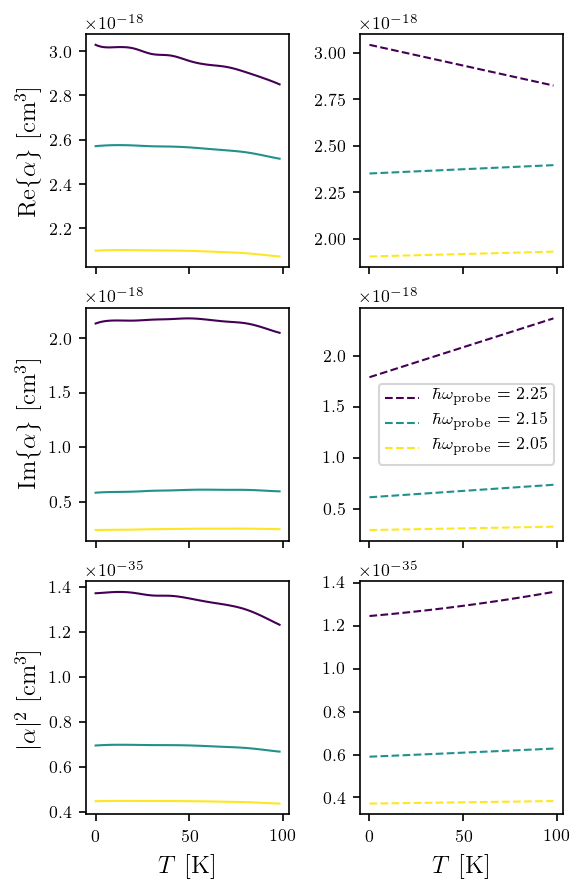

In [31]:
fig, axs = plt.subplots(3, 2, sharex=True, figsize=(4,6))


def plot_data_vs_model_at_2col(hw, color_idx, axs):
    
    alpha_mie_epsdata = np.zeros(99, dtype='complex' )
    alpha_drude = np.zeros_like(alpha_mie_epsdata)
    Ts = np.linspace(0, 98, 99)

    for i in range(99):

        eps_data = hw_eps_T_dict[f'hw_eps_{i:d}K'][1]
        hws_for_eps_data = hw_eps_T_dict[f'hw_eps_{i:d}K'][0]

        ## Get alpha at highest energy
        alpha_mie_epsdata[i] = cp.sparse_sphere_polarizability_Mie(
            eps_data[idx_nearest(hws_for_eps_data, hw)],
            eps_b=eps_back,
            a=a1*1e-7,
            w=hw/hbar,
            )[ 0,0]

        
        heated_particle = pti.single_particle_image(
            hw, 
            eps_inf=drude_fit_0K['x'][0],  # eps_inf
            w_p=drude_fit_0K['x'][1],  # w_p
            gamma=drude_fit_0K['x'][2],  # gamma
            E_probe=E_probe_mag,
            eps0=eps_back)
        alpha_drude[i] = heated_particle.alpha_of_T(
            i, 
            b1*1e-7, 
            a1*1e-7,
            dnr_dt=dndt_at_hw(hw, 0).real,
            dni_dt=dndt_at_hw(hw, 0).imag)

    print(f" For hw = {hw},")
    print(f"dnr_dt={dndt_at_hw(hw, 0).real},")
    print(f"dni_dt={dndt_at_hw(hw, 0).imag},")
    axs[0, 0].plot(
        Ts, 
        np.real(alpha_mie_epsdata), 
        lw=1,    
    #     label=r'$\alpha_\mathrm{Mie}(\epsilon_\mathrm{Drude}(T))|_{T=T_R}$',
        c=mpl.cm.viridis(color_idx),  
        )
    axs[1, 0].plot(
        Ts, 
        np.imag(alpha_mie_epsdata), 
        lw=1,
        c=mpl.cm.viridis(color_idx),
        )
    axs[2, 0].plot(
        Ts, 
        np.abs(alpha_mie_epsdata)**2, 
        lw=1,
        c=mpl.cm.viridis(color_idx),
        )

    axs[0, 1].plot(
        Ts, 
        np.real(alpha_drude), 
        label=r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}',
        lw=1,
        ls='--',
    #     label=r'linear $\alpha(T)|_{T=T_R}$',
        c=mpl.cm.viridis(color_idx),  
        )
    axs[1, 1].plot(
        Ts, 
        np.imag(alpha_drude), 
        label=r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}',
        lw=1,
        c=mpl.cm.viridis(color_idx),  
        ls='--',
        )
    axs[2, 1].plot(
        Ts, 
        np.abs(alpha_drude)**2
       , 
        label=r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}',
        lw=1,
        c=mpl.cm.viridis(color_idx),  
        ls='--',
        )

plot_data_vs_model_at_2col(hw=2.25, color_idx=0/2, axs=axs)
plot_data_vs_model_at_2col(hw=2.15, color_idx=1/2, axs=axs)
plot_data_vs_model_at_2col(hw=2.05, color_idx=2/2, axs=axs)

  
axs[0, 0].set_ylabel(r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$')
# # axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
# lo = Labeloffset(axs[0], label=r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$', axis="y")
# axs[0].yaxis.offsetText.set_visible(False)
axs[1, 0].set_ylabel(r'$\mathrm{Im}\{\alpha\}$ $[\mathrm{cm}^3]$')
axs[2, 0].set_ylabel(r'$|\alpha|^2$ $[\mathrm{cm}^3]$')

# axs[2, 1].set_xlabel(r'$T$ [K]')
axs[2, 0].set_xlabel(r'$T$ [K]')
axs[2, 1].set_xlabel(r'$T$ [K]')


axs[1, 1].legend()
# fig.suptitle(r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}, or {1240/hw.real:.0f} [nm]')

plt.tight_layout()

Something seems wrong here, let me plot the zero temp expression against the data

## Try Drude Lorentz Model

In [32]:
fit_cutoff = 2.

def drude_lorentz_cost(param, *args):

    eps_inf, w_p, gamma, f1, w1 = param
    
    hw, data = args
    
    model = cp.drude_lorentz_model(
        hw/hbar, 
        eps_inf=eps_inf, 
        w_p=w_p, 
        gamma=gamma,
        f_1 = f1,
        w_1 = w1)

    res = (model - data)*(
        hw**10.
#         >fit_cutoff
        )
    
    return np.array([res.real, res.imag]).ravel()
    

In [33]:
ini_params = [au_eps_inf, au_w_p, au_gamma, 0, 1e16]

drude_fit_0K = opt.least_squares(
    drude_lorentz_cost,
    ini_params,
    args=(hw_eps_T_dict[f'hw_eps_0K'][0], hw_eps_T_dict[f'hw_eps_0K'][1]),
    x_scale=[1e2, 1e16, 1e14, 1, 1e16]
    )

/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


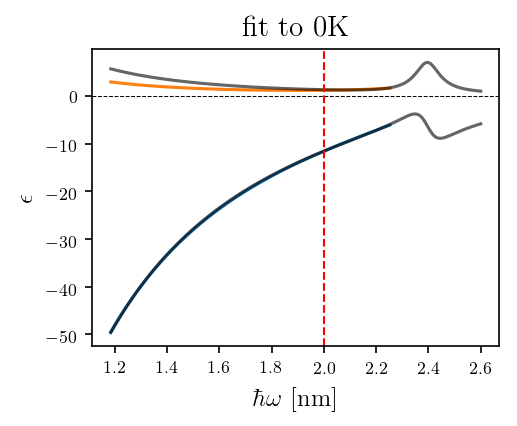

In [34]:

# for i in range(100):
#     plt.plot(hw_eps_T_dict[f'hw_eps_{i:d}K'][0], np.real(hw_eps_T_dict[f'hw_eps_{i:d}K'][1]), c='C0',  alpha=i/100)
#     plt.plot(hw_eps_T_dict[f'hw_eps_{i:d}K'][0], np.imag(hw_eps_T_dict[f'hw_eps_{i:d}K'][1]), c='C1',  alpha=i/100)
# for i in range(100):
plt.plot(hw_eps_T_dict[f'hw_eps_0K'][0], np.real(hw_eps_T_dict[f'hw_eps_0K'][1]), c='C0',  alpha=i/100)
plt.plot(hw_eps_T_dict[f'hw_eps_0K'][0], np.imag(hw_eps_T_dict[f'hw_eps_0K'][1]), c='C1',  alpha=i/100)
    
plt.ylabel(r'$\epsilon$')
plt.xlabel(r'$\hbar\omega$ [nm]')


hw_h = np.linspace(hw_eps_T_dict[f'hw_eps_{i:d}K'][0].min(), 2.6, 200)
fit_drude = cp.drude_lorentz_model(hw_h/hbar, *drude_fit_0K['x'])
plt.plot(
    hw_h,
    np.real(fit_drude),
    c = 'k',
    alpha=.6
    )
plt.plot(
    hw_h,
    np.imag(fit_drude),
    c = 'k',
    alpha=.6
    )

plt.axhline(0, lw=.5, ls='--', c='k')

plt.title('fit to 0K')
plt.axvline(fit_cutoff, c='red', lw=1, ls='--')

In [35]:
heated_particle = pti.single_particle_image(
    hw_h, 
    eps_inf=drude_fit_0K['x'][0],  # eps_inf
    w_p=drude_fit_0K['x'][1],  # w_p
    gamma=drude_fit_0K['x'][2],  # gamma
    E_probe=E_probe_mag,
    eps0=eps_back)

linear_alpha_at0K = heated_particle.alpha_of_T(0, b1*1e-7, a1*1e-7)

## Build Mie polarizability from data


In [36]:
## Build polarizability from 0K data
alpha_mie_epsdata = cp.sparse_sphere_polarizability_Mie(
        hw_eps_T_dict[f'hw_eps_0K'][1],
        eps_b=eps_back,
        a=a1*1e-7,
        w=hw_eps_T_dict[f'hw_eps_0K'][0]/hbar,
        )[:, 0,0]

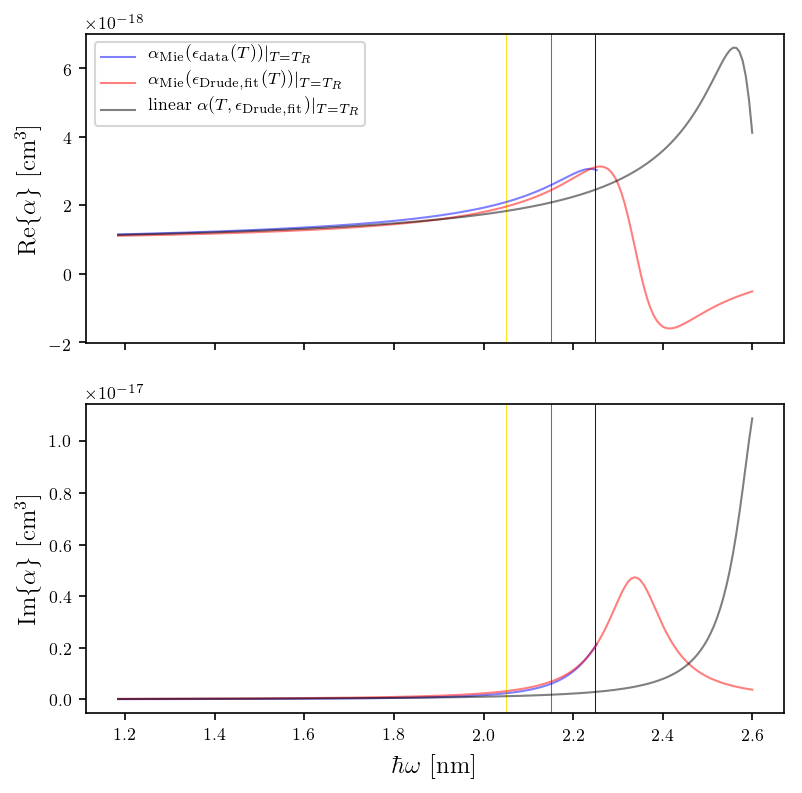

In [37]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6,6))

axs[0].plot(
    hw_eps_T_dict[f'hw_eps_0K'][0], 
    np.real(alpha_mie_epsdata), 
    label=r'$\alpha_\mathrm{Mie}(\epsilon_\mathrm{data}(T))|_{T=T_R}$',
    lw=1,
    c='blue',  alpha=.5)
axs[1].plot(
    hw_eps_T_dict[f'hw_eps_0K'][0], 
    np.imag(alpha_mie_epsdata), 
    lw=1,
    c='blue',  alpha=.5)

axs[0].plot(
    hw_h, 
    np.real(alpha_Drude), 
    label=r'$\alpha_\mathrm{Mie}(\epsilon_\mathrm{Drude, fit}(T))|_{T=T_R}$',
    lw=1,
    c='red',  alpha=.5)
axs[1].plot(
    hw_h, 
    np.imag(alpha_Drude), 
    lw=1,
    c='red',  alpha=.5)

axs[0].plot(
    hw_h, 
    np.real(linear_alpha_at0K),
    label=r'linear $\alpha(T, \epsilon_\mathrm{Drude, fit})|_{T=T_R}$',
    lw=1,
    c='k',  alpha=.5)
axs[1].plot(
    hw_h, 
    np.imag(linear_alpha_at0K),
    lw=1,
    c='k',  alpha=.5)

  
# axs[0].set_ylabel(r'Re[$\alpha(T)/\alpha(0)$]')
# axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
axs[1].set_xlabel(r'$\hbar\omega$ [nm]')
axs[0].set_ylabel(r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$')
axs[1].set_ylabel(r'$\mathrm{Im}\{\alpha\}$ $[\mathrm{cm}^3]$')

axs[0].legend()

axs[0].axvline(2.25, lw=.5, zorder=0, c=mpl.cm.viridis(0))
axs[1].axvline(2.25, lw=.5, zorder=0, c=mpl.cm.viridis(0))

axs[0].axvline(2.15, lw=.5, zorder=0, c=mpl.cm.viridis(.5))
axs[1].axvline(2.15, lw=.5, zorder=0, c=mpl.cm.viridis(.5))

axs[0].axvline(2.05, lw=.5, zorder=0, c=mpl.cm.viridis(2/2))
axs[1].axvline(2.05, lw=.5, zorder=0, c=mpl.cm.viridis(2/2))


